In [67]:
pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [68]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import math
import time
from datetime import datetime
import shutil
import tensorboard
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw, ImageFont
import torchvision.utils as vutils
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import confusion_matrix
import itertools

In [69]:
batch_size=16
chkpoint="/home/ec2-user/SageMaker/checkpoints/uncropped/Model_v2_best.pth.tar"
dropout=0.2

In [70]:
class ZooplanktonDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_names = [name for name in os.listdir(image_folder) if name != ".ipynb_checkpoints"]
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_name

In [71]:
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ZooplanktonDataset(image_folder='/home/ec2-user/SageMaker/prediction_July4/Dataset/',
                            transform=data_transform)

test_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [72]:
class Model_v1(nn.Module):
    def __init__(self):
        super(Model_v1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 26 * 26, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 64 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

In [73]:
# class Model_v2(nn.Module):
#     def __init__(self, dropout):
#         super(Model_v2, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3)
#         self.conv2 = nn.Conv2d(16, 32, 3)
#         self.conv3 = nn.Conv2d(32, 64, 3)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.pool2 = nn.MaxPool2d(3, 2)
#         self.pool3 = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(dropout)
#         self.fc1 = nn.Linear(64 * 26 * 26, 256)
#         self.fc2 = nn.Linear(256, 84)
#         self.fc3 = nn.Linear(84, 2)
#         self.softmax = nn.LogSoftmax(dim=1)
        
#     def forward(self, x):
#         x = self.dropout(F.relu(self.conv1(x)))
#         x = self.pool1(x)
#         x = self.dropout(F.relu(self.conv2(x)))
#         x = self.pool2(x)
#         x = self.dropout(F.relu(self.conv3(x)))
#         x = self.pool3(x)
#         x = x.view(-1, 64 * 26 * 26)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = self.softmax(self.fc3(x))
#         return x

In [74]:
# class Model_v2(nn.Module):
#     def __init__(self, dropout):
#         super(Model_v2, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3)
#         self.conv2 = nn.Conv2d(16, 32, 3)
#         self.conv3 = nn.Conv2d(32, 64, 3)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.pool2 = nn.MaxPool2d(3, 2)
#         self.pool3 = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(dropout)
#         self.fc1 = nn.Linear(64 * 26 * 26, 256)
#         self.fc2 = nn.Linear(256, 84)
#         self.fc3 = nn.Linear(84, 2)
#         self.softmax = nn.LogSoftmax(dim=1)
        
#     def forward(self, x):
#         x = self.dropout(F.relu(self.conv1(x)))
#         x = self.pool1(x)
#         x = self.dropout(F.relu(self.conv2(x)))
#         x = self.pool2(x)
#         x = self.dropout(F.relu(self.conv3(x)))
#         x = self.pool3(x)
#         x = x.view(-1, 64 * 26 * 26)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = self.softmax(self.fc3(x))
#         return x

In [75]:
# accepts 256x256
import torch.nn as nn
import torch.nn.functional as F

class Model_v2(nn.Module):
    def __init__(self, dropout):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adjusting the fully connected layers to fit the spatial dimensions
        # of the input image (256x256)
        self.fc1 = nn.Linear(64 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x


In [76]:
# import torch.nn as nn

# class Model_v2(nn.Module):
#     def __init__(self, dropout):
#         super(Model_v2, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.fc1 = nn.Linear(128 * 37 * 37, 512)  # Calculate the input size based on 300x300 input images
#         self.relu4 = nn.ReLU()
#         self.dropout = nn.Dropout(dropout)  # Use the provided dropout value
#         self.fc2 = nn.Linear(512, 2)  # Output layer with 2 neurons for binary classification

#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, x):
#         x = self.pool1(self.relu1(self.conv1(x)))
#         x = self.pool2(self.relu2(self.conv2(x)))
#         x = self.pool3(self.relu3(self.conv3(x)))

#         x = x.view(-1, 128 * 37 * 37)  # Flatten the tensor
#         x = self.dropout(self.relu4(self.fc1(x)))
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x


In [77]:
class Model_v3(nn.Module):
    def __init__(self):
        super(Model_v3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 26 * 26, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        self.ln = nn.LayerNorm(64 * 26 * 26)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 64 * 26 * 26)
        x = self.ln(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

In [78]:

class Trainer:
    def __init__(self, model, test_data_loader, save_dir, with_cuda,tensorboard_dir, print_freq=1):
        self.device = torch.device("cuda:0" if with_cuda else "cpu")
        self.model = model
        self.test_data_loader = test_data_loader
        self.save_dir = save_dir
        self.print_freq = print_freq
        self.step = 0
        self.accuracy = 0
        self.tensorboard_dir = tensorboard_dir
        self.start_time = datetime.now().strftime('%b-%d_%H-%M')
        if not os.path.exists(self.tensorboard_dir):
            os.makedirs(self.tensorboard_dir)
        self.writer = SummaryWriter(log_dir=self.tensorboard_dir)

    def predict(self):
        checkpoint = torch.load(chkpoint)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.eval()
        images = []
        predicted_labels = []
        names = []

        for batch_images, image_names in self.test_data_loader:
            with torch.no_grad():
                if self.device:
                    batch_images = batch_images.to(self.device)

                # Forward pass to obtain predicted labels for each item in the batch
                batch_outputs = self.model(batch_images)
                batch_predicted_labels = torch.argmax(batch_outputs, dim=1)

            # Iterate over each item in the batch
            for i in range(batch_images.size(0)):
                image = vutils.make_grid(batch_images[i], nrow=1, padding=10, normalize=True)
                predicted_label = batch_predicted_labels[i]
                name = image_names[i]

                images.append(image)
                predicted_labels.append(predicted_label)
                names.append(name)
        
        
        zooplankton_dir = os.path.join(self.save_dir, 'Detected')
        marine_snow_dir = os.path.join(self.save_dir, 'Not-Detected')

        # Delete directories if they exist
        if os.path.exists(zooplankton_dir):
            shutil.rmtree(zooplankton_dir)
        if os.path.exists(marine_snow_dir):
            shutil.rmtree(marine_snow_dir)

        # Create directories
        os.makedirs(zooplankton_dir)
        os.makedirs(marine_snow_dir)

        # Save the classified images into respective directories based on their predicted labels
        for i in range(len(images)):
            image = images[i]
            predicted_label = predicted_labels[i]
            image_name = names[i]
            # Save the image to the appropriate directory based on the predicted label
            if predicted_label == 1:
                save_path = os.path.join(zooplankton_dir, image_name)
            else:
                save_path = os.path.join(marine_snow_dir, image_name)

            vutils.save_image(image, save_path, normalize=True)

        # Log the images on TensorBoard
        for i, image in enumerate(images):
            image_name = names[i]
            label = predicted_labels[i]
            self.writer.add_image(f"Image-{i}-Predicted-{label}", image.cpu(), global_step=i)

        # Close the SummaryWriter object
        self.writer.close()


In [79]:
    #model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Model_v2(dropout)
    model.to(device)
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    #creating object for tensorboard_dir
    tensorboard_dir = '/home/ec2-user/SageMaker/prediction_July4/runs/'

In [80]:
 trainer = Trainer(
        model,
        test_data_loader=test_loader,
        save_dir='/home/ec2-user/SageMaker/prediction_July4/',
        with_cuda=True,
        tensorboard_dir=tensorboard_dir)

In [81]:
trainer.predict()

# Make csv

In [82]:
import os
import csv
import shutil

folder1_path = '/home/ec2-user/SageMaker/prediction_July4/Detected'
folder2_path = '/home/ec2-user/SageMaker/prediction_July4/Not-Detected'
csv_file_path = '/home/ec2-user/SageMaker/prediction_July4/UnModified_prediction.csv'

folder1_images = os.listdir(folder1_path)
folder2_images = os.listdir(folder2_path)

data = []
for image_name in folder1_images:
    data.append([image_name, 'Detected'])

for image_name in folder2_images:
    data.append([image_name, 'NotDetected'])

with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image Name', 'Label'])
    writer.writerows(data)

print(f"CSV file created: {csv_file_path}")

CSV file created: /home/ec2-user/SageMaker/prediction_July4/UnModified_prediction.csv


# Comparing and creating confusion matrix

Accuracy: 92.00


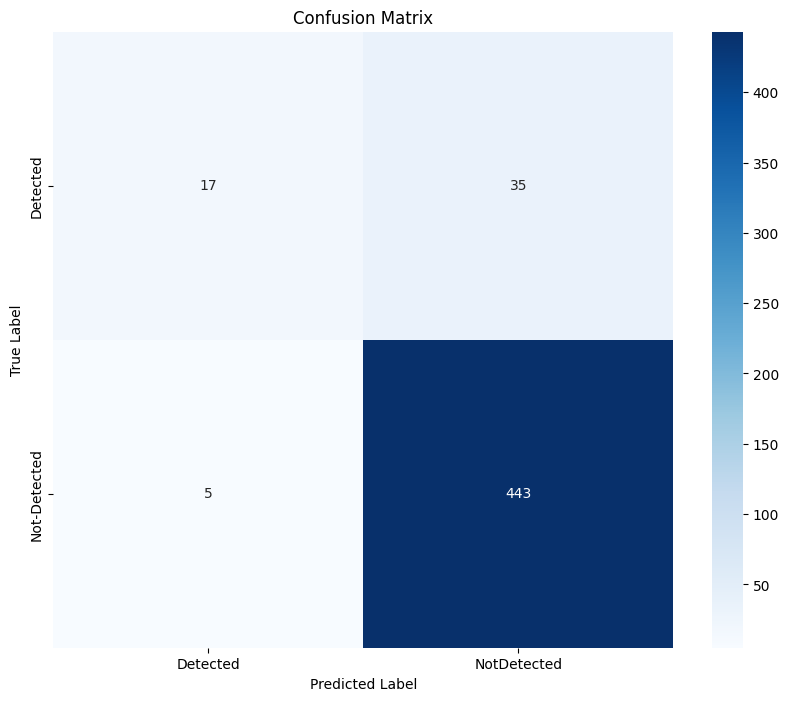

In [83]:
df1 = pd.read_csv('/home/ec2-user/SageMaker/prediction_July4/2023-07-06_Natasha.csv')
df2 = pd.read_csv('/home/ec2-user/SageMaker/prediction_July4/UnModified_prediction.csv')
df1 = df1.iloc[:, [1, 9]]
df1 = df1.rename(columns={'2: Video or Image Identifier': 'Image Name','10-11+: Repeated Species':'Label'})
df1 = df1.drop_duplicates(subset='Image Name').reset_index(drop=True)
df1['Label'] = 'Detected'
merged_df = df1.merge(df2, on='Image Name', how='outer')
merged_df['Label_x'].fillna('Not-Detected', inplace=True)
confusion_matrix = merged_df.groupby(['Label_x', 'Label_y']).size().unstack(fill_value=0)

# Calculate accuracy
correct_predictions = np.diag(confusion_matrix).sum()
total_predictions = confusion_matrix.values.sum()
accuracy = correct_predictions / total_predictions * 100
print(f'Accuracy: {accuracy:.2f}')

#visulaization

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(70, 2)
(40, 2)
Accuracy: 94.40


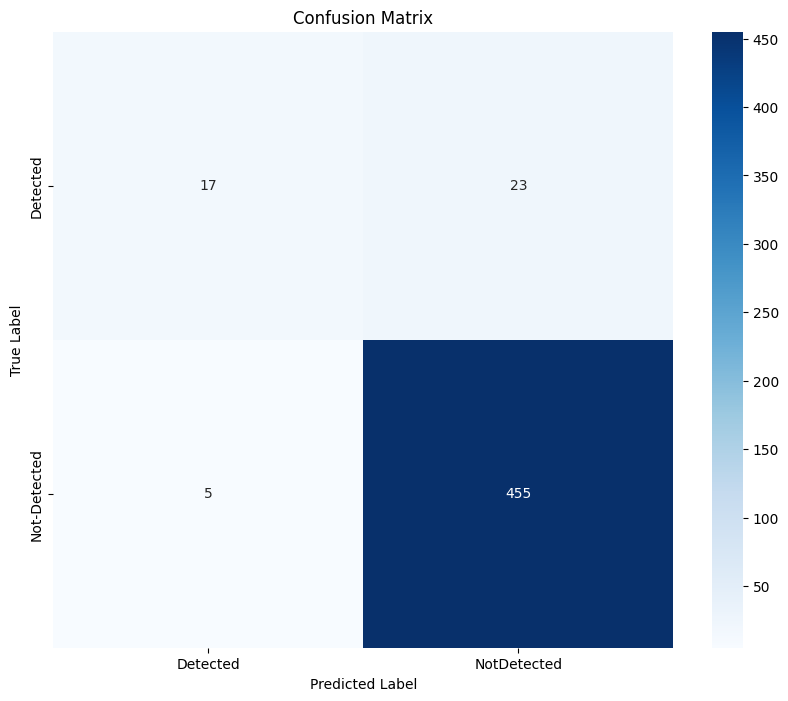

In [84]:
df1 = pd.read_csv('/home/ec2-user/SageMaker/prediction_July4/2023-07-06_Natasha.csv')
df2 = pd.read_csv('/home/ec2-user/SageMaker/prediction_July4/UnModified_prediction.csv')
df1 = df1.iloc[:, [1, 9]]
print(df1.shape)
df1 = df1.rename(columns={'2: Video or Image Identifier': 'Image Name','10-11+: Repeated Species':'Label'})
values_to_drop = ['hydrozoa-maybe', 'copepod-maybe', 'copepod-maybe-edge', 'echinoderm-larva-maybe', 'unknown']
df1 = df1[~df1.iloc[:, 1].isin(values_to_drop)]
df1 = df1.drop_duplicates(subset='Image Name').reset_index(drop=True)
print(df1.shape)
df1['Label'] = 'Detected'
merged_df = df1.merge(df2, on='Image Name', how='outer')
merged_df['Label_x'].fillna('Not-Detected', inplace=True)
confusion_matrix = merged_df.groupby(['Label_x', 'Label_y']).size().unstack(fill_value=0)

# Calculate accuracy
correct_predictions = np.diag(confusion_matrix).sum()
total_predictions = confusion_matrix.values.sum()
accuracy = correct_predictions / total_predictions * 100
print(f'Accuracy: {accuracy:.2f}')

#visulaization

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

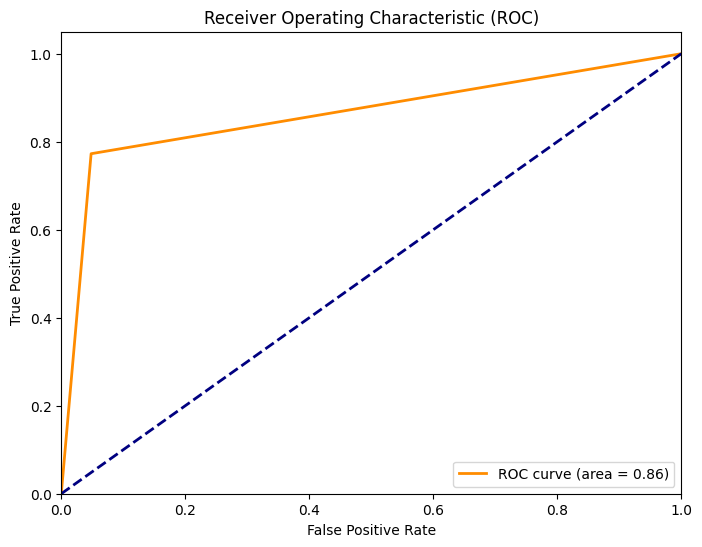

In [85]:
from sklearn.metrics import roc_curve,auc
# Convert labels to binary values
merged_df['Label_y'] = np.where(merged_df['Label_y'] == 'Detected', 1, 0)
merged_df['Label_x'] = np.where(merged_df['Label_x'] == 'Detected', 1, 0)

# Calculate TPR and FPR
tn, fp, fn, tp = confusion_matrix.values.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(merged_df['Label_y'], merged_df['Label_x'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
